In [ ]:
!pip install xgboost
!pip install tqdm

In [9]:
# 1.) imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

In [2]:
# 2.) load training and testing data

# if you want to use this, replace this with where your data is
train_path = "https://raw.githubusercontent.com/liangkyle08/RootedCBH_pka/refs/heads/main/datasets/train_split.csv"
test_path = "https://raw.githubusercontent.com/liangkyle08/RootedCBH_pka/refs/heads/main/datasets/test_split.csv"

# load CSVs
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# drop 'file' and 'predicted_rf (pKa)' if they exist
df_train = df_train.drop(columns=["file"], errors="ignore").dropna()
df_test = df_test.drop(columns=["file", "predicted_rf (pKa)"], errors="ignore").dropna()

In [3]:
# # 3.) set target and split into features and labels

target = "exp_pKa (pKa)"  # we want get close to this (basically the control)

X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_test = df_test.drop(columns=[target])
y_test = df_test[target]
evalset = [(X_train, y_train), (X_test,y_test)]

In [4]:
# 4.) Filter numeric features and align columns

# keep only numeric columns
X_train = X_train.select_dtypes(include=["number"])
X_test = X_test.select_dtypes(include=["number"])

# align test columns to match train (drop any extra or missing ones)
X_test = X_test[X_train.columns]

In [5]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from xgboost import XGBRegressor
from tqdm import tqdm
import numpy as np

# Parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# List of all combinations
all_params = list(ParameterGrid(param_grid))

best_score = -np.inf
best_model = None
best_params = None

# Progress bar over all parameter combinations
for params in tqdm(all_params, desc="Grid search"):
    model = XGBRegressor(random_state=42, **params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = scores.mean()
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params



Grid search: 100%|██████████| 48/48 [03:06<00:00,  3.89s/it]


In [ ]:
# ~~~ OLD CODE WITHOUT PROGRESS BAR ~~~
"""from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Set up model and grid search
base_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_

# Predict using the tuned model
y_pred = model.predict(X_test)"""

Mean Squared Error: 0.575
R² Score: 0.941


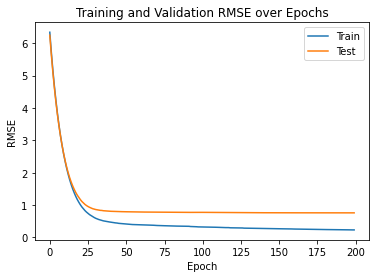

In [16]:
# Train with evaluation set
evalset = [(X_train, y_train), (X_test, y_test)]
best_model = XGBRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset, verbose=False)

# Predict and evaluate
yhat = best_model.predict(X_test)
mse = mean_squared_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

# Retrieve and plot learning curve
results = best_model.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Training and Validation RMSE over Epochs')
plt.legend()
plt.show()

Mean Absolute Error: 0.515
R² Score: 0.941


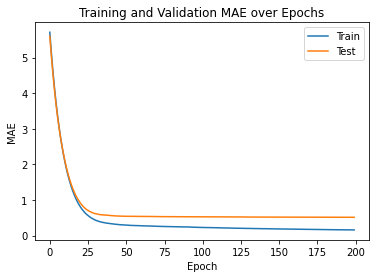

In [17]:
# Train with evaluation set
evalset = [(X_train, y_train), (X_test, y_test)]
best_model = XGBRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train, eval_metric='mae', eval_set=evalset, verbose=False)

# Predict and evaluate
yhat = best_model.predict(X_test)
mae = mean_absolute_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

# Retrieve and plot learning curve
results = best_model.evals_result()
plt.plot(results['validation_0']['mae'], label='Train')
plt.plot(results['validation_1']['mae'], label='Test')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.title('Training and Validation MAE over Epochs')
plt.legend()
plt.show()

Root Mean Squared Error (RMSE): 0.7580
MAE: 0.5146


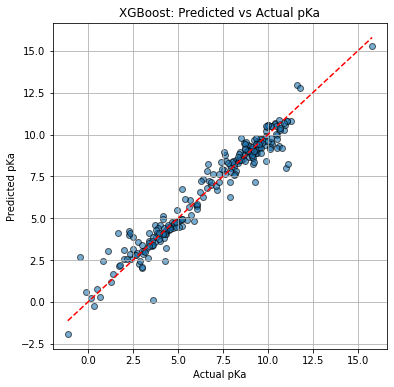

In [7]:
# run the test1 ML(RDKit + RootedCBH + QM)

#rmse = mean_squared_error(y_test, y_pred, squared=False) doesnt work :(

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"MAE: {mae:.4f}")
# Plot predicted vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual pKa")
plt.ylabel("Predicted pKa")
plt.title("XGBoost: Predicted vs Actual pKa")
plt.grid(True)
plt.show()

In [ ]:
# === TRAINING AND TEST RMSE vs EPOCH PLOT ===

from xgboost import XGBRegressor

eval_result = {}
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",
    verbose=False,
    evals_result=eval_result
)


# Plot train/test RMSE over epochs
epochs = range(len(eval_result['validation_0']['rmse']))
plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_result['validation_0']['rmse'], label="Train RMSE")
plt.plot(epochs, eval_result['validation_1']['rmse'], label="Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training and Test RMSE vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# === SPIDER PLOT FOR FUNCTIONAL GROUP MAE ===

import numpy as np

# Define your functional group columns (replace with real ones)
functional_groups = ['has_OH', 'has_NH2', 'has_COOH']  # Example only!

group_errors = []
labels_found = []

for fg in functional_groups:
    if fg in X_test.columns:
        mask = X_test[fg] == 1
        if mask.sum() > 0:
            group_mae = mean_absolute_error(y_test[mask], y_pred[mask])
            group_errors.append(group_mae)
            labels_found.append(fg)

# Radar chart
stats = np.array(group_errors)
labels = np.array(labels_found)
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats, [stats[0]]))  # close loop
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, stats, marker='o', label='MAE per group')
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Spider Plot: Functional Group MAE")
ax.grid(True)
plt.legend()
plt.show()
